•	EDA: Explore multicollinearity using variance inflation factors, pinpoint heteroscedasticity, and delineate variable relationships.

# Import Packages and Data

In [34]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px

warnings.filterwarnings("ignore", category=FutureWarning)

In [35]:
branch_level_data = pd.read_csv('data/Branch_Level_Dataset.csv')
branch_level_data.head(5)

,EOM_TRANS_DATE,BranchCategory,ATM,Bill Payment,Cash,Draft,ACH,Fee,Credit/Debit Card,Home Banking,Dividend
0,2022-01-31,Addition Financial Arena,0,3,0,28,5,20,6,4,14
1,2022-01-31,Altamonte Springs,98,394,64,469,1589,416,1642,646,3650
2,2022-01-31,Apopka,198,540,132,705,2219,560,1983,724,5731
3,2022-01-31,Boone High School,1,10,2,8,30,9,80,21,59
4,2022-01-31,Clermont,143,482,103,499,1940,539,1834,580,4551


# Data Preprocessing

In [36]:
# Remove rows where BranchCategory is 'High School' or 'Virtual Branch'
branch_level_data = branch_level_data[~branch_level_data['BranchCategory'].str.contains("High School|Virtual Branch")]

# Check for null values in the DataFrame
null_values = branch_level_data.isnull().sum()

# Displaying the DataFrame and the null values information
print(branch_level_data.head())
print(null_values)


  EOM_TRANS_DATE            BranchCategory  ATM  Bill Payment  Cash  Draft  \
0     2022-01-31  Addition Financial Arena    0             3     0     28   
1     2022-01-31         Altamonte Springs   98           394    64    469   
2     2022-01-31                    Apopka  198           540   132    705   
4     2022-01-31                  Clermont  143           482   103    499   
6     2022-01-31           Downtown Campus   27            35    12     62   

    ACH  Fee  Credit/Debit Card  Home Banking  Dividend  
0     5   20                  6             4        14  
1  1589  416               1642           646      3650  
2  2219  560               1983           724      5731  
4  1940  539               1834           580      4551  
6   134   78                227            47       275  
EOM_TRANS_DATE       0
BranchCategory       0
ATM                  0
Bill Payment         0
Cash                 0
Draft                0
ACH                  0
Fee                  0

In [37]:
import pandas as pd

# Load the Excel file
file_path = 'data/countyrevenuesbycategory.xlsx'
df_revenue = pd.read_excel(file_path)

# Selecting only the 'County' and 'TOTAL - All Revenue Account Codes' columns
# Assuming these are the first and the third-last columns in your DataFrame
df_revenue = df_revenue.iloc[:, [0, -3]]

# Renaming the columns for clarity
df_revenue.columns = ['County', 'Revenue_Per_County']

# Dropping the first row if it contains headers from the original table
df_revenue = df_revenue.drop(0)

# Displaying the modified DataFrame
print(df_revenue.head())



     County Revenue_Per_County
1   Alachua         1082349199
2     Baker           89157684
3       Bay         1193216378
4  Bradford           85933027
5   Brevard          958971976


In [38]:
import pandas as pd

# Map BranchCategory to County
city_to_county_mapping = {
    'Addition Financial Arena': 'Orange',
    'Altamonte Springs': 'Seminole',
    'Apopka': 'Orange',
    'Clermont': 'Lake',
    'Downtown Campus': 'Orange',
    'East Orlando': 'Orange',
    'Eustis': 'Lake',
    'Fern Park': 'Seminole',
    'Kissimmee': 'Osceola',
    'Lake Mary': 'Seminole',
    'Lake Nona': 'Orange',
    'Leesburg': 'Lake',
    'Longwood': 'Seminole',
    'Merritt Island': 'Brevard',
    'MetroWest': 'Orange',
    'Mills': 'Orange',
    'Orange City': 'Volusia',
    'Oviedo': 'Seminole',
    'Pine Hills': 'Orange',
    'Poinciana': 'Polk',
    'Sanford': 'Seminole',
    'Seminole State': 'Seminole',
    'South Orlando': 'Orange',
    'St. Cloud': 'Osceola',
    'The Loop': 'Osceola',
    'UCF Campus': 'Orange',
    'UCF Commons': 'Orange',
    'Winter Garden': 'Orange'
}

branch_level_data['County'] = branch_level_data['BranchCategory'].map(city_to_county_mapping)

# Load revenue data
file_path = 'data/countyrevenuesbycategory.xlsx'
df_revenue = pd.read_excel(file_path)

# Selecting only 'County' and 'TOTAL - All Revenue Account Codes' columns
df_revenue = df_revenue.iloc[:, [0, -3]]
df_revenue.columns = ['County', 'Revenue_Per_County']
df_revenue = df_revenue.drop(0)

# Merging the DataFrames
branch_level_data = pd.merge(branch_level_data, df_revenue, on='County', how='left')

# Displaying the combined DataFrame
branch_level_data.head()


,EOM_TRANS_DATE,BranchCategory,ATM,Bill Payment,Cash,Draft,ACH,Fee,Credit/Debit Card,Home Banking,Dividend,County,Revenue_Per_County
0,2022-01-31,Addition Financial Arena,0,3,0,28,5,20,6,4,14,Orange,6968835122
1,2022-01-31,Altamonte Springs,98,394,64,469,1589,416,1642,646,3650,Seminole,1830400546
2,2022-01-31,Apopka,198,540,132,705,2219,560,1983,724,5731,Orange,6968835122
3,2022-01-31,Clermont,143,482,103,499,1940,539,1834,580,4551,Lake,1003940427
4,2022-01-31,Downtown Campus,27,35,12,62,134,78,227,47,275,Orange,6968835122


In [39]:
# Dropping unnecessary columns
pre_normalized_df = branch_level_data.drop(['EOM_TRANS_DATE', 'BranchCategory', 'County'], axis=1)
pre_normalized_df.head()

,ATM,Bill Payment,Cash,Draft,ACH,Fee,Credit/Debit Card,Home Banking,Dividend,Revenue_Per_County
0,0,3,0,28,5,20,6,4,14,6968835122
1,98,394,64,469,1589,416,1642,646,3650,1830400546
2,198,540,132,705,2219,560,1983,724,5731,6968835122
3,143,482,103,499,1940,539,1834,580,4551,1003940427
4,27,35,12,62,134,78,227,47,275,6968835122


In [40]:
from sklearn.preprocessing import StandardScaler

# Create the Scaler object
scaler = StandardScaler()

# Fit the data on the scaler object
normalized_df = scaler.fit_transform(pre_normalized_df)

# Convert the normalized DataFrame into a DataFrame
normalized_df = pd.DataFrame(normalized_df, columns=pre_normalized_df.columns)
normalized_df.columns = [col + '_norm' for col in normalized_df.columns]
normalized_df.head()

,ATM_norm,Bill Payment_norm,Cash_norm,Draft_norm,ACH_norm,Fee_norm,Credit/Debit Card_norm,Home Banking_norm,Dividend_norm,Revenue_Per_County_norm
0,-1.449119,-0.617278,-1.138159,-1.348628,-1.026666,-1.596365,-1.436047,-1.445617,-1.484872,1.174476
1,-0.279600,0.138588,0.004137,0.433753,0.592510,0.099428,-0.040356,0.380911,0.030027,-0.718847
2,0.913787,0.420829,1.217827,1.387589,1.236501,0.716080,0.250555,0.602826,0.897052,1.174476
3,0.257424,0.308706,0.700224,0.555003,0.951305,0.626152,0.123441,0.193137,0.405418,-1.023367
4,-1.126905,-0.555417,-0.923979,-1.211211,-0.894802,-1.347991,-1.247509,-1.323280,-1.376130,1.174476


# PCA Analysis

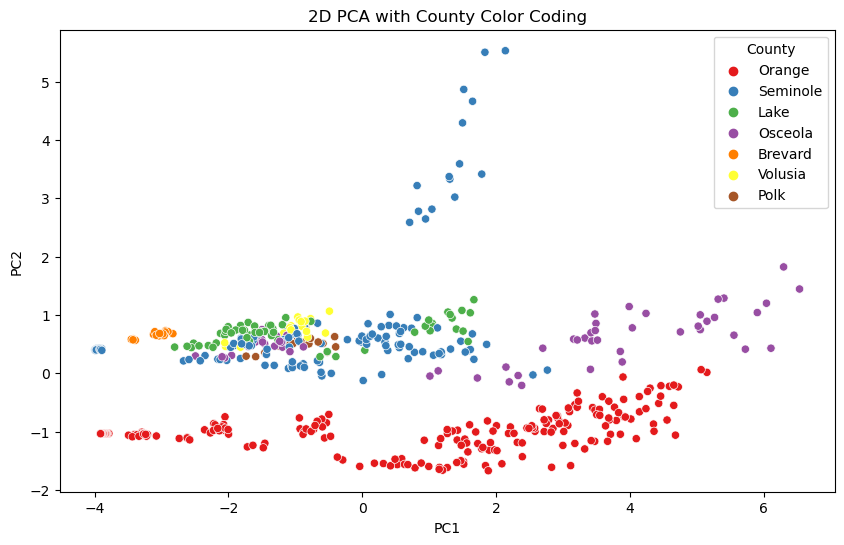

In [41]:
# Apply 2D PCA
from sklearn.decomposition import PCA


pca_2d = PCA(n_components=2)
pca_result_2d = pca_2d.fit_transform(normalized_df)

# Create a DataFrame for 2D PCA results
pca_df_2d = pd.DataFrame(data=pca_result_2d, columns=['PC1', 'PC2'])
pca_df_2d['County'] = branch_level_data['County']

# Plot 2D PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='County', data=pca_df_2d, palette='Set1')
plt.title('2D PCA with County Color Coding')
plt.show()

In [42]:
# Get the feature loadings for PC1 and PC2
loadings_df = pd.DataFrame(pca_2d.components_, columns=normalized_df.columns, index=['PC1', 'PC2'])

# Display the feature loadings
print("Feature Loadings for PC1:")
print(loadings_df.loc['PC1'].sort_values(ascending=False))

print("\nFeature Loadings for PC2:")
print(loadings_df.loc['PC2'].sort_values(ascending=False))

Feature Loadings for PC1:
Home Banking_norm          0.373792
Draft_norm                 0.368642
Fee_norm                   0.368490
Dividend_norm              0.361914
ATM_norm                   0.340146
Credit/Debit Card_norm     0.333748
Cash_norm                  0.320335
ACH_norm                   0.312615
Bill Payment_norm          0.157848
Revenue_Per_County_norm    0.072590
Name: PC1, dtype: float64

Feature Loadings for PC2:
Bill Payment_norm          0.583762
ACH_norm                   0.184610
Draft_norm                 0.052828
Home Banking_norm          0.050569
Cash_norm                 -0.020902
Fee_norm                  -0.043528
Dividend_norm             -0.074373
Credit/Debit Card_norm    -0.087620
ATM_norm                  -0.159068
Revenue_Per_County_norm   -0.760888
Name: PC2, dtype: float64


In [43]:
# Apply 3D PCA
pca_3d = PCA(n_components=3)
pca_result_3d = pca_3d.fit_transform(normalized_df)

# Create a DataFrame for 3D PCA results
pca_df_3d = pd.DataFrame(data=pca_result_3d, columns=['PC1', 'PC2', 'PC3'])
pca_df_3d['County'] = branch_level_data['County']

# Plot 3D PCA with Plotly
fig = px.scatter_3d(pca_df_3d, x='PC1', y='PC2', z='PC3', color='County', labels={'County': 'County'}, 
                    title='3D PCA with County Color Coding', opacity=0.7, width=1100, height=800,
                    color_discrete_sequence=px.colors.qualitative.Set1)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.update_traces(marker_size=5)
fig.update_layout(legend_title_text='County', legend=dict(yanchor="top", y=0.79, xanchor="left", x=0.01))

# Show the interactive 3D plot
fig.show()

In [44]:
# Get the feature loadings for PC1, PC2, and PC3
loadings_df = pd.DataFrame(pca_3d.components_, columns=normalized_df.columns, index=['PC1', 'PC2', 'PC3'])

# Display the feature loadings
print("Feature Loadings for PC1:")
print(loadings_df.loc['PC1'].sort_values(ascending=False))

print("\nFeature Loadings for PC2:")
print(loadings_df.loc['PC2'].sort_values(ascending=False))

print("\nFeature Loadings for PC3:")
print(loadings_df.loc['PC3'].sort_values(ascending=False))

Feature Loadings for PC1:
Home Banking_norm          0.373792
Draft_norm                 0.368642
Fee_norm                   0.368490
Dividend_norm              0.361914
ATM_norm                   0.340146
Credit/Debit Card_norm     0.333748
Cash_norm                  0.320335
ACH_norm                   0.312615
Bill Payment_norm          0.157848
Revenue_Per_County_norm    0.072590
Name: PC1, dtype: float64

Feature Loadings for PC2:
Bill Payment_norm          0.583762
ACH_norm                   0.184610
Draft_norm                 0.052828
Home Banking_norm          0.050569
Cash_norm                 -0.020902
Fee_norm                  -0.043528
Dividend_norm             -0.074373
Credit/Debit Card_norm    -0.087620
ATM_norm                  -0.159068
Revenue_Per_County_norm   -0.760888
Name: PC2, dtype: float64

Feature Loadings for PC3:
Revenue_Per_County_norm    0.621193
Bill Payment_norm          0.575591
ACH_norm                   0.311414
Cash_norm                  0.065945
Draf